<a href="https://colab.research.google.com/github/CaptnPogChamp10/mamun-haidar-ali.github.io/blob/main/ODMR_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

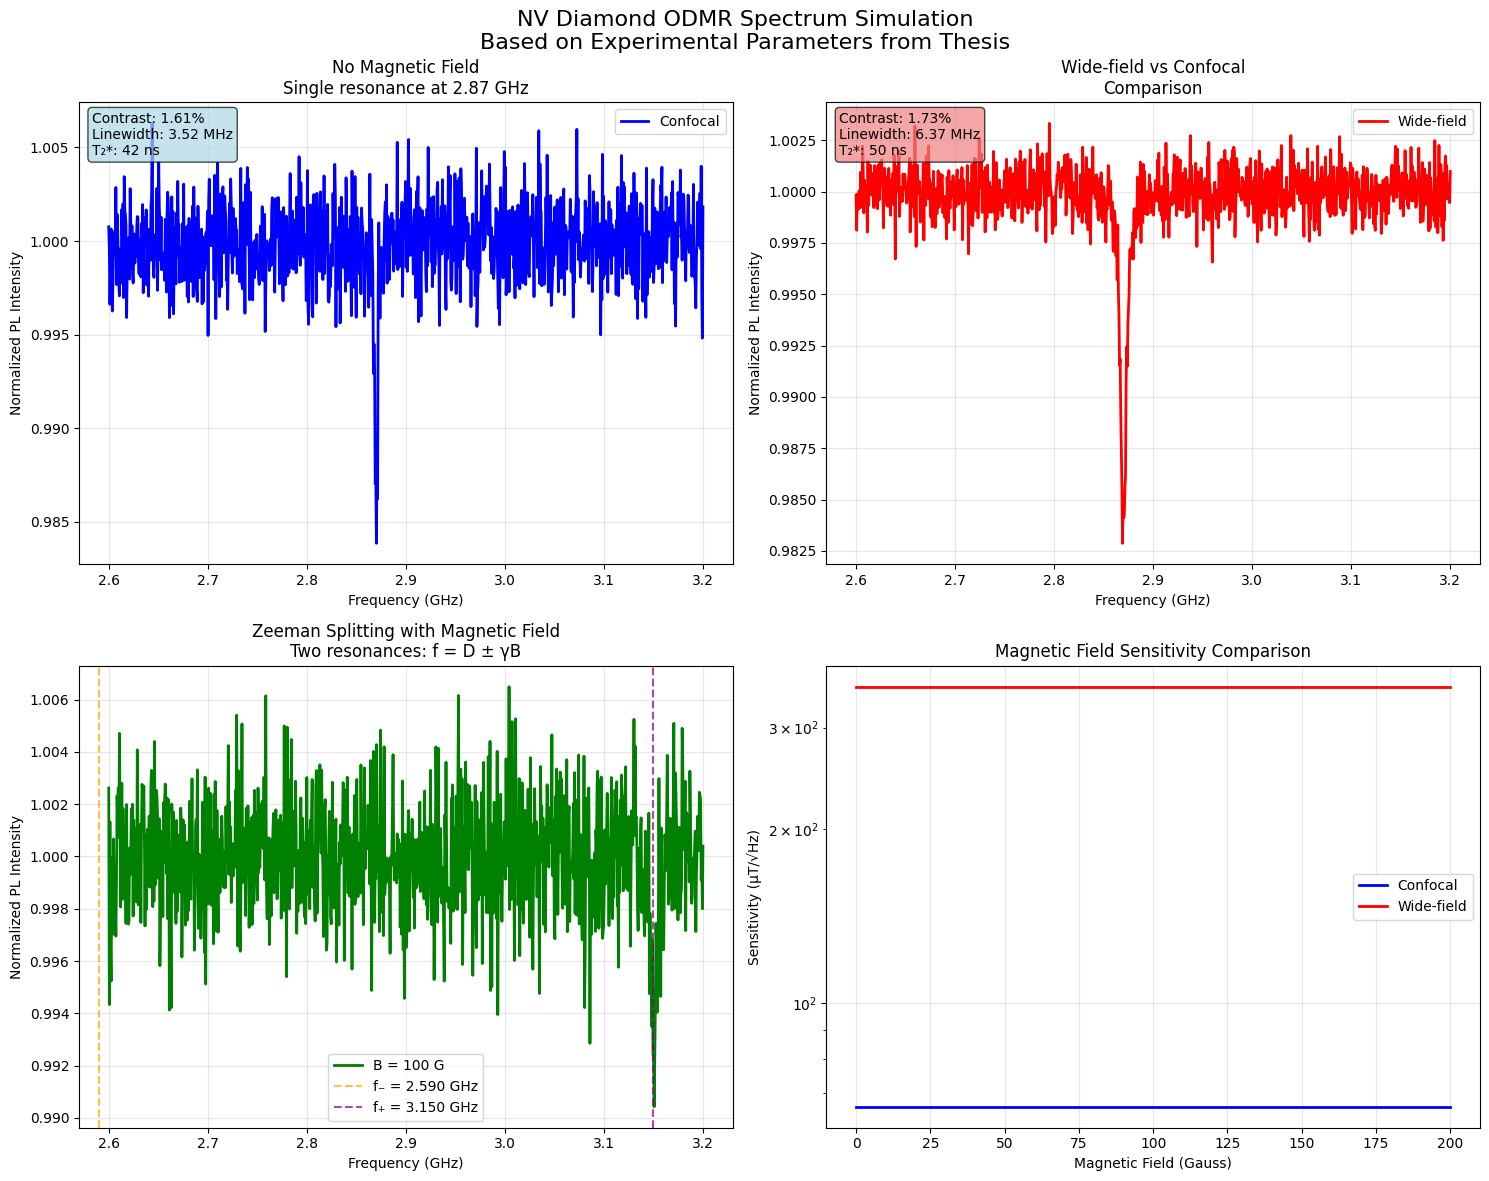

=== ODMR Simulation Summary ===
Frequency range: 2.6 - 3.2 GHz
Zero-field splitting D: 2.870 GHz
Gyromagnetic ratio γ: 2.8 MHz/G

Confocal Parameters:
  Contrast: 1.61%
  Linewidth: 3.52 MHz
  T₂*: 42 ns
  Sensitivity: 66.15 μT/√Hz

Wide-field Parameters:
  Contrast: 1.73%
  Linewidth: 6.37 MHz
  T₂*: 50 ns
  Sensitivity: 353.12 μT/√Hz

=== Fitted Parameters ===
Center frequency: 2.869937 GHz
Linewidth (FWHM): 3.14 MHz
Contrast: 1.91%
Baseline: 1.0000


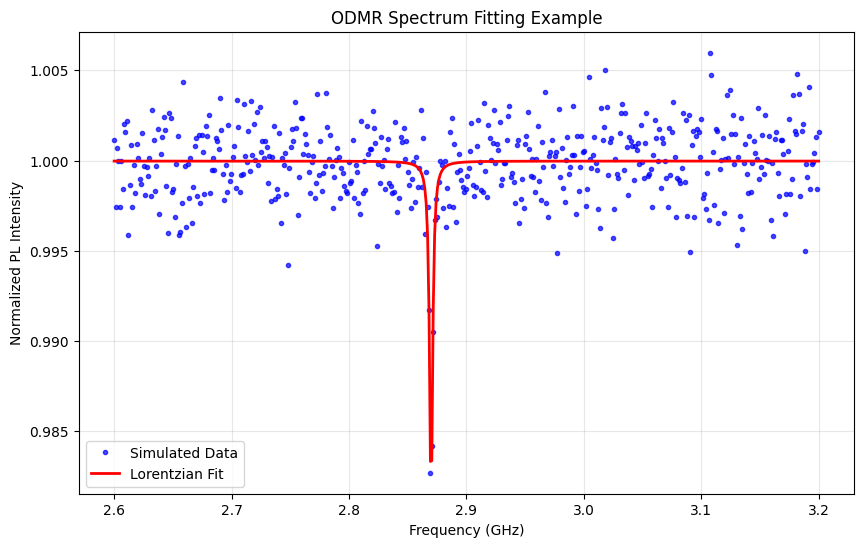

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import random

class ODMRSimulator:
    """
    Simulates ODMR spectra for NV centers in diamond based on experimental parameters
    from the thesis: "Nitrogen-Vacancy-Based Diamond Wide-Field Magnetometer"
    """

    def __init__(self):
        # Physical constants
        self.gamma_e = 2.8e6  # Gyromagnetic ratio (Hz/Gauss)
        self.D_gs = 2.87e9    # Zero-field splitting (Hz)

        # Experimental parameters from thesis
        self.confocal_params = {
            'contrast': 0.0161,      # 1.61%
            'linewidth': 3.52e6,     # 3.52 MHz
            'T2_star': 42e-9,        # 42 ns
            'sensitivity': 66.15e-6, # 66.15 μT/√Hz
            'baseline_noise': 0.002  # Piezo drift/laser instability
        }

        self.widefield_params = {
            'contrast': 0.0173,      # 1.73%
            'linewidth': 6.37e6,     # 6.37 MHz
            'T2_star': 50e-9,        # 50 ns
            'sensitivity': 353.12e-6, # 353.12 μT/√Hz
            'baseline_noise': 0.001  # Better stability due to differential imaging
        }

    def lorentzian(self, f, f0, gamma, amplitude, offset):
        """Lorentzian lineshape for ODMR resonances"""
        return offset - amplitude * (gamma/2)**2 / ((f - f0)**2 + (gamma/2)**2)

    def gaussian_noise(self, size, noise_level):
        """Generate realistic experimental noise"""
        return np.random.normal(0, noise_level, size)

    def simulate_no_field_odmr(self, frequencies, measurement_type='confocal'):
        """
        Simulate ODMR spectrum without external magnetic field
        Single resonance at D_gs = 2.87 GHz
        """
        params = self.confocal_params if measurement_type == 'confocal' else self.widefield_params

        # Base PL signal (normalized)
        baseline = 1.0

        # Single Lorentzian dip at 2.87 GHz
        odmr_signal = self.lorentzian(
            frequencies,
            self.D_gs,
            params['linewidth'],
            params['contrast'],
            baseline
        )

        # Add experimental noise
        noise = self.gaussian_noise(len(frequencies), params['baseline_noise'])
        odmr_signal += noise

        return odmr_signal

    def simulate_with_field_odmr(self, frequencies, B_field_gauss, measurement_type='confocal'):
        """
        Simulate ODMR spectrum with external magnetic field
        Two peaks due to Zeeman splitting: f = D ± γB
        """
        params = self.confocal_params if measurement_type == 'confocal' else self.widefield_params

        # Calculate Zeeman-split frequencies
        zeeman_shift = self.gamma_e * B_field_gauss
        f_minus = self.D_gs - zeeman_shift
        f_plus = self.D_gs + zeeman_shift

        baseline = 1.0

        # Two Lorentzian dips (thesis shows different linewidths for split peaks)
        if measurement_type == 'confocal':
            # From thesis: linewidths 3.53 MHz and 5.36 MHz
            linewidth_1 = 3.53e6
            linewidth_2 = 5.36e6
        else:
            # Wide-field: assume similar broadening for both peaks
            linewidth_1 = linewidth_2 = params['linewidth']

        odmr_signal = baseline
        odmr_signal = self.lorentzian(frequencies, f_minus, linewidth_1, params['contrast']/2, odmr_signal)
        odmr_signal = self.lorentzian(frequencies, f_plus, linewidth_2, params['contrast']/2, odmr_signal)

        # Add experimental noise
        noise = self.gaussian_noise(len(frequencies), params['baseline_noise'])
        odmr_signal += noise

        return odmr_signal, f_minus, f_plus

    def calculate_sensitivity(self, frequencies, odmr_signal, measurement_type='confocal'):
        """
        Calculate magnetic field sensitivity based on ODMR contrast and linewidth
        Sensitivity = linewidth / (contrast * sqrt(count_rate))
        """
        params = self.confocal_params if measurement_type == 'confocal' else self.widefield_params

        # Find the steepest slope (highest sensitivity point)
        gradient = np.gradient(odmr_signal, frequencies)
        max_slope = np.max(np.abs(gradient))

        # Theoretical sensitivity (from thesis)
        theoretical_sensitivity = params['sensitivity']

        return theoretical_sensitivity, max_slope

    def fit_odmr_spectrum(self, frequencies, odmr_signal, num_peaks=1):
        """
        Fit ODMR spectrum with Lorentzian(s) to extract parameters
        """
        if num_peaks == 1:
            # Single peak fit
            # Initial guess: [f0, gamma, amplitude, offset]
            p0 = [self.D_gs, 3e6, 0.015, 1.0]
            try:
                popt, pcov = curve_fit(self.lorentzian, frequencies, odmr_signal, p0=p0)
                return popt, pcov
            except:
                return p0, None
        else:
            # For two peaks, we'd need a double Lorentzian function
            # Simplified: just find the two minima
            peaks_inv, _ = find_peaks(-odmr_signal, height=-1.1, distance=len(frequencies)//10)
            if len(peaks_inv) >= 2:
                f1, f2 = frequencies[peaks_inv[:2]]
                return [f1, f2], None
            return [self.D_gs-1e6, self.D_gs+1e6], None

def plot_odmr_comparison():
    """
    Create comprehensive ODMR simulation plots comparing different conditions
    """
    simulator = ODMRSimulator()

    # Frequency range from thesis: 2.6-3.2 GHz
    frequencies = np.linspace(2.6e9, 3.2e9, 1000)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('NV Diamond ODMR Spectrum Simulation\nBased on Experimental Parameters from Thesis', fontsize=16)

    # 1. No magnetic field - Confocal
    ax1 = axes[0, 0]
    odmr_no_field_conf = simulator.simulate_no_field_odmr(frequencies, 'confocal')
    ax1.plot(frequencies/1e9, odmr_no_field_conf, 'b-', linewidth=2, label='Confocal')
    ax1.set_xlabel('Frequency (GHz)')
    ax1.set_ylabel('Normalized PL Intensity')
    ax1.set_title('No Magnetic Field\nSingle resonance at 2.87 GHz')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Add experimental parameters as text
    ax1.text(0.02, 0.98, f'Contrast: 1.61%\nLinewidth: 3.52 MHz\nT₂*: 42 ns',
             transform=ax1.transAxes, verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

    # 2. No magnetic field - Wide-field
    ax2 = axes[0, 1]
    odmr_no_field_wf = simulator.simulate_no_field_odmr(frequencies, 'widefield')
    ax2.plot(frequencies/1e9, odmr_no_field_wf, 'r-', linewidth=2, label='Wide-field')
    ax2.set_xlabel('Frequency (GHz)')
    ax2.set_ylabel('Normalized PL Intensity')
    ax2.set_title('Wide-field vs Confocal\nComparison')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Add experimental parameters
    ax2.text(0.02, 0.98, f'Contrast: 1.73%\nLinewidth: 6.37 MHz\nT₂*: 50 ns',
             transform=ax2.transAxes, verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

    # 3. With magnetic field - Zeeman splitting
    ax3 = axes[1, 0]
    B_field = 100  # Gauss
    odmr_with_field, f_minus, f_plus = simulator.simulate_with_field_odmr(frequencies, B_field, 'confocal')
    ax3.plot(frequencies/1e9, odmr_with_field, 'g-', linewidth=2, label=f'B = {B_field} G')
    ax3.axvline(f_minus/1e9, color='orange', linestyle='--', alpha=0.7, label=f'f₋ = {f_minus/1e9:.3f} GHz')
    ax3.axvline(f_plus/1e9, color='purple', linestyle='--', alpha=0.7, label=f'f₊ = {f_plus/1e9:.3f} GHz')
    ax3.set_xlabel('Frequency (GHz)')
    ax3.set_ylabel('Normalized PL Intensity')
    ax3.set_title('Zeeman Splitting with Magnetic Field\nTwo resonances: f = D ± γB')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # 4. Sensitivity comparison
    ax4 = axes[1, 1]
    B_fields = np.linspace(0, 200, 50)
    sensitivities_conf = []
    sensitivities_wf = []

    for B in B_fields:
        if B == 0:
            odmr_conf = simulator.simulate_no_field_odmr(frequencies, 'confocal')
            odmr_wf = simulator.simulate_no_field_odmr(frequencies, 'widefield')
        else:
            odmr_conf, _, _ = simulator.simulate_with_field_odmr(frequencies, B, 'confocal')
            odmr_wf, _, _ = simulator.simulate_with_field_odmr(frequencies, B, 'widefield')

        sens_conf, _ = simulator.calculate_sensitivity(frequencies, odmr_conf, 'confocal')
        sens_wf, _ = simulator.calculate_sensitivity(frequencies, odmr_wf, 'widefield')

        sensitivities_conf.append(sens_conf * 1e6)  # Convert to μT
        sensitivities_wf.append(sens_wf * 1e6)

    ax4.plot(B_fields, sensitivities_conf, 'b-', linewidth=2, label='Confocal')
    ax4.plot(B_fields, sensitivities_wf, 'r-', linewidth=2, label='Wide-field')
    ax4.set_xlabel('Magnetic Field (Gauss)')
    ax4.set_ylabel('Sensitivity (μT/√Hz)')
    ax4.set_title('Magnetic Field Sensitivity Comparison')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    ax4.set_yscale('log')

    plt.tight_layout()
    plt.show()

    # Print summary of simulated parameters
    print("=== ODMR Simulation Summary ===")
    print(f"Frequency range: 2.6 - 3.2 GHz")
    print(f"Zero-field splitting D: {simulator.D_gs/1e9:.3f} GHz")
    print(f"Gyromagnetic ratio γ: {simulator.gamma_e/1e6:.1f} MHz/G")
    print("\nConfocal Parameters:")
    print(f"  Contrast: {simulator.confocal_params['contrast']*100:.2f}%")
    print(f"  Linewidth: {simulator.confocal_params['linewidth']/1e6:.2f} MHz")
    print(f"  T₂*: {simulator.confocal_params['T2_star']*1e9:.0f} ns")
    print(f"  Sensitivity: {simulator.confocal_params['sensitivity']*1e6:.2f} μT/√Hz")
    print("\nWide-field Parameters:")
    print(f"  Contrast: {simulator.widefield_params['contrast']*100:.2f}%")
    print(f"  Linewidth: {simulator.widefield_params['linewidth']/1e6:.2f} MHz")
    print(f"  T₂*: {simulator.widefield_params['T2_star']*1e9:.0f} ns")
    print(f"  Sensitivity: {simulator.widefield_params['sensitivity']*1e6:.2f} μT/√Hz")

def demonstrate_fitting():
    """
    Demonstrate ODMR spectrum fitting and parameter extraction
    """
    simulator = ODMRSimulator()
    frequencies = np.linspace(2.6e9, 3.2e9, 500)

    # Simulate spectrum with some noise
    odmr_signal = simulator.simulate_no_field_odmr(frequencies, 'confocal')

    # Fit the spectrum
    fitted_params, covariance = simulator.fit_odmr_spectrum(frequencies, odmr_signal, num_peaks=1)

    if covariance is not None:
        # Generate fitted curve
        fitted_curve = simulator.lorentzian(frequencies, *fitted_params)

        plt.figure(figsize=(10, 6))
        plt.plot(frequencies/1e9, odmr_signal, 'b.', alpha=0.7, label='Simulated Data')
        plt.plot(frequencies/1e9, fitted_curve, 'r-', linewidth=2, label='Lorentzian Fit')
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Normalized PL Intensity')
        plt.title('ODMR Spectrum Fitting Example')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Extract parameters
        f0, gamma, amplitude, offset = fitted_params
        print(f"\n=== Fitted Parameters ===")
        print(f"Center frequency: {f0/1e9:.6f} GHz")
        print(f"Linewidth (FWHM): {gamma/1e6:.2f} MHz")
        print(f"Contrast: {amplitude*100:.2f}%")
        print(f"Baseline: {offset:.4f}")

        plt.show()
    else:
        print("Fitting failed - check initial parameters")

# Run the simulation
if __name__ == "__main__":
    plot_odmr_comparison()
    demonstrate_fitting()